# Data Science and COVID-19

This Jupyter notebook analyses publicly available data on COVID-19 infections and deaths using the ```pandas``` data framework.

## Datasets
The data on COVID-19 is published by European Centre for Disease Prevention and Control and can be downloaded daily from https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx

Population data is taken from the World Bank (included in the dataset above).

Start by downloading the latest data:

In [91]:
!curl -O https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  655k  100  655k    0     0   978k      0 --:--:-- --:--:-- --:--:--  978k


Read the data into a pandas Dataframe. Use the ```dateRep``` column as the index:

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_excel("COVID-19-geographic-disbtribution-worldwide.xlsx").set_index("dateRep")

## Overview
The dataset contains worldwide data on all countries. Note that each daily entry only includes the *new* cases/deaths for that day:

In [93]:
df

,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
dateRep,,,,,,,,,,
2020-05-01,1,5,2020,222,4,Afghanistan,AF,AFG,37172386.0,Asia
2020-04-30,30,4,2020,122,0,Afghanistan,AF,AFG,37172386.0,Asia
2020-04-29,29,4,2020,124,3,Afghanistan,AF,AFG,37172386.0,Asia
2020-04-28,28,4,2020,172,0,Afghanistan,AF,AFG,37172386.0,Asia
2020-04-27,27,4,2020,68,10,Afghanistan,AF,AFG,37172386.0,Asia
...,...,...,...,...,...,...,...,...,...,...
2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0,Africa
2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa


The dataset includes worldwide data:

In [94]:
# list of countries available in the data set
print("Number of countries in data set: %d" % len(df["countriesAndTerritories"].unique()))

Number of countries in data set: 208


# COVID Infections and Deaths
This section looks at numbers of recorded infections and deaths and how these vary across countries.

## Total cases / deaths
Start with the recorded COVID-19 cases and deaths of worldwide and for some selected countries:

In [95]:
countries=["China", "Italy", "United_Kingdom", "France", "United_States_of_America", "Spain", "Germany", "Austria"]

def print_df(df, label):
    df_c = df[["cases", "deaths"]].sum()
    print(label)
    print("\tcases: %s" % df_c["cases"])
    print("\tdeaths: %s" % df_c["deaths"])
    
# worldwide
print_df(df, "Worldwide")
# for selected countries
for c in countries:
    print_df(df[df["countriesAndTerritories"] == c], c)


Worldwide
	cases: 3214256
	deaths: 232570
China
	cases: 83956
	deaths: 4637
Italy
	cases: 205463
	deaths: 27967
United_Kingdom
	cases: 171253
	deaths: 26771
France
	cases: 129581
	deaths: 24376
United_States_of_America
	cases: 1069826
	deaths: 63006
Spain
	cases: 213435
	deaths: 24543
Germany
	cases: 159119
	deaths: 6288
Austria
	cases: 15457
	deaths: 584


Now group the data set by country ready for the next section of country-based statistics:

In [96]:
# sum total of cases and deaths by country
cases_deaths_df = df.groupby(by="countriesAndTerritories")[["cases", "deaths"]].sum()
cases_deaths_df

,cases,deaths
countriesAndTerritories,,
Afghanistan,2171,64
Albania,773,31
Algeria,4006,450
Andorra,745,42
Angola,27,2
...,...,...
Vietnam,270,0
Western_Sahara,6,0
Yemen,6,2


## Top 20 countries with highest number of recorded infection cases

Start with a simple plot of the overall infection numbers per country. This compares the absolute figures and does not take into account the population of a country.

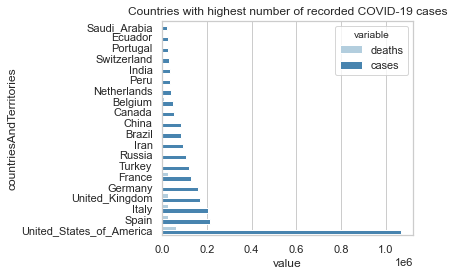

In [97]:
# use seaborn for nicer graphs
import seaborn as sns
sns.set(style="whitegrid")

df_graph = cases_deaths_df.sort_values("cases")[["deaths", "cases"]].tail(20)

# seaborn needs index as a column (via reset_index) and convert to long-form via pd.melt
df_graph_sns = pd.melt(df_graph.reset_index(), ["countriesAndTerritories"])
sns.barplot(x="value",
            y="countriesAndTerritories",
            hue="variable",
            data=df_graph_sns,
            palette="Blues").set_title("Countries with highest number of recorded COVID-19 cases")

#df_graph.plot(kind="barh", title="Countries with highest number of recorded COVID-19 cases")
plt.tight_layout()
plt.savefig("docs/graphs/totals/countries_with_highest_number_of_recorded_COVID-19_cases.png")

### Remarks
Countries with larger populations appear higher in the lists simply as a result of the size.

Also, the statistics do not consider how the levels of testing vary across countries. There appears to be a significant difference across countries which directly affects the numbers of recorded cases. This can be due to many reasons:
* Differences in government policy: some countries placed increased importance on widespread testing in order to isolate carriers and to better understand the spread within the population
* Availability of testing: some countries have been able to use national manufacturing capacity to make tests available while other countries have found this more difficult.
* Prioritisation: many countries focus testing on patients with severe symptoms. Many patients have either mild symptoms or are asymptomatic so are not tested.

Some estimates indicate that only 3% of populations are being tested for COVID-19 which would suggest a significant number of undetected infections.

## Top 20 countries with highest recorded deaths
This graph shows those countries with the highest number of COVID-19 deaths.
Again, the figures are presented directly without any scaling to take into account the population size (see below for mortality rates).

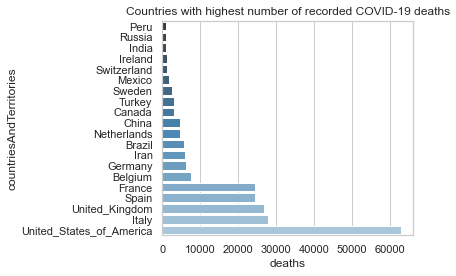

In [98]:
# using dataframe.plot
#cases_deaths_df.sort_values("deaths").tail(20).plot(kind="barh", y=["deaths"], title="Countries with highest number of recorded COVID-19 deaths")

# using seaborn
sns.barplot(x="deaths",
            y="countriesAndTerritories",
            data=cases_deaths_df.sort_values("deaths").tail(20).reset_index(),
            palette="Blues_d").set_title("Countries with highest number of recorded COVID-19 deaths")

plt.tight_layout()
plt.savefig("docs/graphs/totals/countries_with_highest_number_of_recorded_covid-19_deaths.png")

### Remarks
Figures for COVID-19 deaths may be more accurate than those of infections (due to the significant under-counting of infections for the reasons cited above). However:

* Policies for recording COVID-19 deaths are not consistent across countries. Some countries record any the death in the COVID statistics if the deceased had contracted COVID-19 while other countries only record the death if the COVID-19 was deemed to be the underlying cause.
* Conversely, it is generally accepted that people will be dying due to COVID-related causes but will not be tested retroactively to classify this as a COVID-19 death.

## Countries with no recorded COVID-19 deaths
At the time of writing, the list of countries with COVID-19 cases that has yet to experience any COVID-19 related deaths is:

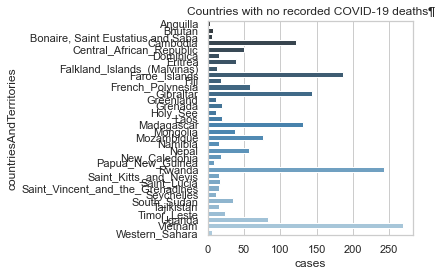

In [99]:
no_deaths = cases_deaths_df[cases_deaths_df["deaths"] == 0].index
#print("Number of countries without COVID-19 deaths: %d" % len(no_deaths))
#print("\n".join(no_deaths))

# plot countries in a graph
sns.barplot(y="countriesAndTerritories",
            x="cases",
            data=cases_deaths_df[cases_deaths_df["deaths"] == 0].reset_index(),
            palette="Blues_d").set_title("Countries with no recorded COVID-19 deaths¶")
plt.tight_layout()
plt.savefig("docs/graphs/totals/countries_with_no_recorded_covid-19_deaths.png")
plt.show()

# Infection rates

This section looks at metrics that are more independent of the underlying population and allow comparisons between countries.

## Top 20 countries with highest COVID-19 infection and mortality rates
This graph adjusts for population size by expressing all cases and deaths in terms of the underlying population size (i.e. infection/mortality rates). Countries with missing population data are excluded.

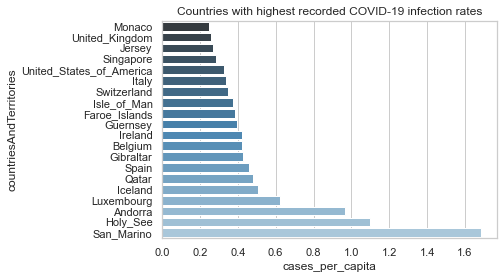

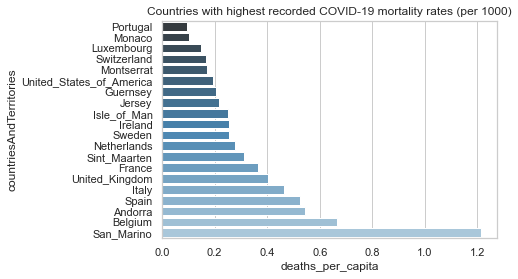

In [100]:
# top 20 worst pop/death and pop/cases ratios
cases_deaths_pop_df = cases_deaths_df.join(df.set_index("countriesAndTerritories")["popData2018"].drop_duplicates(), rsuffix="right")

# drop rows with missing population data
cases_deaths_pop_df = cases_deaths_pop_df.dropna(subset=["popData2018"])

# unclear what this data set is
cases_deaths_pop_df = cases_deaths_pop_df.drop(index="Cases_on_an_international_conveyance_Japan")

cases_deaths_pop_df["cases_per_capita"] = cases_deaths_pop_df["cases"] / cases_deaths_pop_df["popData2018"] * 100
cases_deaths_pop_df["deaths_per_capita"] = cases_deaths_pop_df["deaths"] / cases_deaths_pop_df["popData2018"] * 1000

# infection rates
#cases_deaths_df.sort_values("cases_per_capita").tail(20).plot(kind="barh", y="cases_per_capita", title="Countries with highest recorded COVID-19 infection rates")
sns.barplot(x="cases_per_capita",
            y="countriesAndTerritories",
            data=cases_deaths_pop_df.sort_values("cases_per_capita").tail(20).reset_index(),
            palette="Blues_d").set_title("Countries with highest recorded COVID-19 infection rates")
plt.show()
# mortality rates
#cases_deaths_df.sort_values("deaths_per_capita").tail(20).plot(kind="barh", y="deaths_per_capita", title="Countries with highest recorded COVID-19 mortality rates")
sns.barplot(x="deaths_per_capita",
            y="countriesAndTerritories",
            data=cases_deaths_pop_df.sort_values("deaths_per_capita").tail(20).reset_index(),
            palette="Blues_d").set_title("Countries with highest recorded COVID-19 mortality rates (per 1000)")
plt.show()

### Remarks
While many of the hotspot countries (Italy, Spain) are still present, some of the larger countries no longer appear in the graphs (notably USA: while the recorded infections are far higher than any other countries, this is still lower when population size is taken into consideration).

As before, differences in testing policies and recording deaths will skew the statistics. Countries with particularly small populations can also appear disproportionately (e.g. San Marino, Luxembourg, Guernsey, Monaco). This may be due to statistical margins of errors, or may indicate that the official populations do not accurately reflect the numbers of active people in the country (e.g. large numbers of frontier workes travelling across borders can significantly increase the intra-day population).

## Case Fatality Rates (CFR)
This metric calculates the proportion of deaths compared to the recorded cases. It describes the likelihood of a COVID-19 infection being fatal.

While this removes the bias against population sizes, the figures are still subject to the same issues relating from the recording of the raw data (level of testing; classification of death as COVID-related etc). Unlike the Infection Fatality Rate, these graphs only use recorded cases and do not try to take account of undiagnosed cases. 

Worldwide CFR: 7.24%


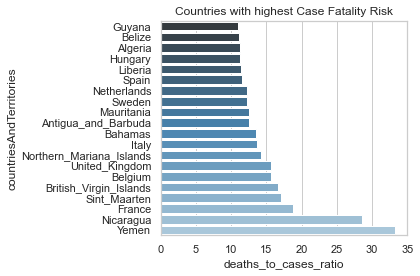

In [101]:
df_all = df[["cases", "deaths"]].sum()
print("Worldwide CFR: %.2f%%" % (df_all["deaths"].astype(int) / df_all["cases"].astype(int) * 100))

# top 20 worst death/cases ratios
cases_deaths_pop_df["deaths_to_cases_ratio"] = cases_deaths_pop_df["deaths"] / cases_deaths_pop_df["cases"] * 100

#cases_deaths_df.sort_values("deaths_to_cases_ratio").tail(20).plot(kind="barh", y="deaths_to_cases_ratio", title="Countries with highest Case Fatality Risk")
sns.barplot(x="deaths_to_cases_ratio",
            y="countriesAndTerritories",
            data=cases_deaths_pop_df.sort_values("deaths_to_cases_ratio").tail(20).reset_index(),
            palette="Blues_d").set_title("Countries with highest Case Fatality Risk")
plt.tight_layout()
plt.savefig("docs/graphs/totals/countries_with_highest_case_fatality_risk.png")
plt.show()

### Remarks
The majority of top countries are under-developed nations. This may indicate limitations in the health care systems (where a COVID infection has an increased risk of a fatality), and/or be a result of more limited testing programmes (which reduce the number of recorded infections).

More generally, there is agreement that the numbers of recorded infections is significantly lower than the actual infections. In these cases, the CFR metric should be treated with caution (currently over 5% worldwide). This is likely to be significantly higher than the real Infection Fatality Rate (which estimates the actual numbers of infections).

# Evolution of COVID-19
The following graphs look at how the COVID-19 infection rate is changing over time.
This can identify peak infection rates (where the number of new infections is at its highest) and show how these vary across countries.

The graphs also show how infection curves flatten (how quickly the number of new cases reduces).

## Cumulative infections and mortalities
These graphs show how the total number of COVID-19 infections/deaths has evolved over time for some selected countries. The gradients of the curves show how the spread of the virus is changing: a steep curve shows large numbers of new cases when the virus is spreading the quickest while a flatter curve shows when the virus is either yet to start speading (start of the curve) or is slowing (top of the curve).

The 1st graphs shows the cases and deaths worldwide. Subsequent graphs break down the figures for selected countries.

In [102]:
# plot worldwide cases first
import matplotlib.patches as mpatches
import yaml
df_all = df[["cases", "deaths"]].sort_index().cumsum()

# save statistics to a data file
totals = df_all.tail(1).values.tolist()[0]
with open(r"docs/_data/statistics.yml", 'w') as file:
    documents = yaml.dump({"cases": {"value": totals[0]}, "deaths": {"value": totals[1]}}, file)

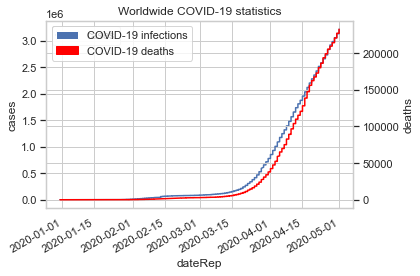

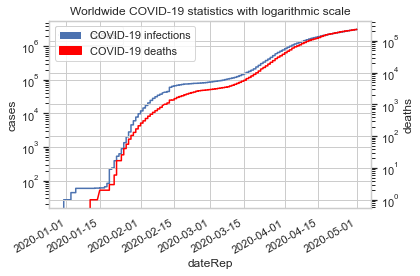

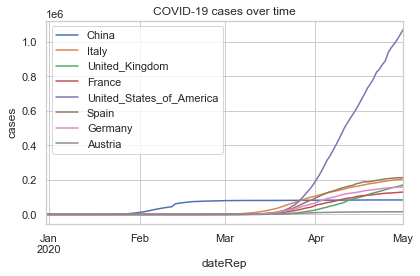

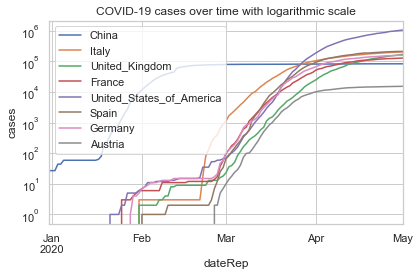

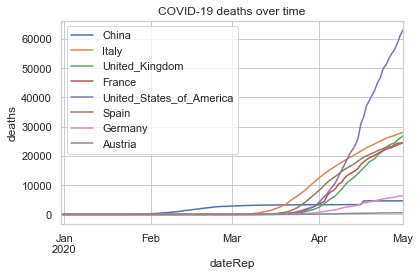

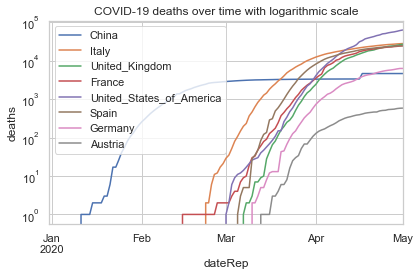

In [103]:
ax_cases = df_all.plot(y="cases", title="Worldwide COVID-19 statistics", logy=False)
ax_cases.set_ylabel("cases")
ax_deaths = ax_cases.twinx()
df_all.plot(y="deaths", ax=ax_deaths, color="red")
ax_deaths.set_ylabel("deaths")

plt.legend(handles=[mpatches.Patch(label="COVID-19 infections"), mpatches.Patch(color="red", label="COVID-19 deaths")], loc=2)
plt.tight_layout()
plt.savefig("docs/graphs/totals/worldwide_covid-19_statistics.png")

ax_cases = df_all.plot(y="cases", title="Worldwide COVID-19 statistics with logarithmic scale", logy=True)
ax_cases.set_ylabel("cases")
ax_deaths = ax_cases.twinx()
df_all.plot(y="deaths", ax=ax_deaths, color="red", logy=True)
ax_deaths.set_ylabel("deaths")

plt.legend(handles=[mpatches.Patch(label="COVID-19 infections"), mpatches.Patch(color="red", label="COVID-19 deaths")], loc=2)
plt.tight_layout()
plt.savefig("docs/graphs/totals/worldwide_covid-19_statistics_with_logarithmic_scale.png")

# helper function to plot selected countries
def plot_over_time(y, title, filename):
    for log_scaling, title_suffix, file_suffix in [(False, "", ""), (True, " with logarithmic scale", "_with_logarithmic_scale")]:
        ax = None
        for c in countries:
            # transform daily delta into cumulative
            df_c = df[df["countriesAndTerritories"] == c][["cases", "deaths"]].sort_index().cumsum()

            ax = df_c.plot(ax=ax, y=y, title=title + title_suffix, logy=log_scaling)

        ax.set_ylabel(y)
        ax.legend(countries)
        plt.tight_layout()
        plt.savefig(filename + file_suffix + ".png")

plot_over_time("cases", "COVID-19 cases over time", "docs/graphs/totals/covid-19_cases_over_time")
plot_over_time("deaths", "COVID-19 deaths over time", "docs/graphs/totals/covid-19_deaths_over_time")

### Remarks
All governments are aiming to keep the peak of the curve as low as possible to reduce the numbers of infections and overall deaths. However, the shape of the curve is key to understanding the spread of the virus and project the evolution. Much of the news coverage talks of 'flattenning the curve' in order to:

* Maintain the number of new infections within the capacity of the health service in order to increase the likelihood of recovery
* Determine the most appropriate measures to put in place and when these can be adapted. For example, severe social distancing measures (lockdowns) can only be relaxed once the curve has shown to be notably flattening.

As the rate of infection decreases, the curves starts to flatten (eventually flattenning completely as no new cases are discovered). Note how the gradients of the curves - indicating the rates of new infections/deaths - vary across countries. This may be due to many reasons (more effective policies, differences in health case and health system capacity, differences in demographics etc).

Note how some countries are starting to flatten the curve (Europe, China) which indicates a slowdown in the virus. However, the current worldwide trajectory does not suggest the peak has been reached.

## Infection and mortality rates over time
These graphs show the numbers of infections and deaths as a percentage of the underlying population.
This takes account of population size and - as with some of the earlier graphs - allows figures to be compared across countries.

As before, any variations in data collection methods, testing policies etc will skew the statistics.

<Figure size 432x288 with 0 Axes>

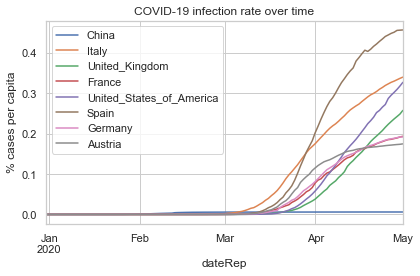

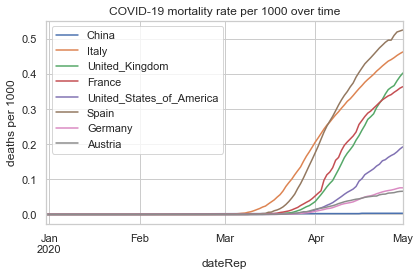

In [104]:
# COVID-19 cases/deaths for selected countries (scales as rates per capita)
fig = plt.figure()
fig.tight_layout()

plot_data = {}

# prepare the data separately from plotting
for c in countries:
    # transform daily delta into cumulative cases and deaths
    df_c = df[df["countriesAndTerritories"] == c][["cases", "deaths"]].sort_index().cumsum()
    
    # lookup population from raw data (no join because missing country)
    population = df[df["countriesAndTerritories"] == c]["popData2018"].iloc[0]
    
    df_c["cases_rate"] = df_c["cases"] / population * 100 # as %
    df_c["deaths_rate"] = df_c["deaths"] / population * 1000 # per 1000
    
    # store the data in a dictionary
    plot_data[c] = df_c

# plot infection rates
ax_cases = None
for c, df_c in plot_data.items():
    ax_cases = df_c.plot(ax=ax_cases, y="cases_rate", title="COVID-19 infection rate over time", legend=False)
ax_cases.set_ylabel("% cases per capita")
ax_cases.legend(plot_data.keys())
plt.tight_layout()
plt.savefig("docs/graphs/rates/covid-19_infection_rate_over_time.png")

# plot mortality rates
# plot infection rates
ax_deaths = None
for c, df_c in plot_data.items():
    ax_deaths = df_c.plot(ax=ax_deaths, y="deaths_rate", title="COVID-19 mortality rate per 1000 over time")
ax_deaths.set_ylabel("deaths per 1000")
ax_deaths.legend(plot_data.keys())
plt.tight_layout()
plt.savefig("docs/graphs/rates/covid-19_mortality_rate_per_1000_over_time.png")

### Remarks
Note how the gradients of the curves - indicating the infection/mortality rates - vary across countries. For example, Italy and Spain have broadly similar numbers of infections, but when scaled as as fraction of the underyling populations, the Spanish infection rate is rather higher. Note also how the gradient of the curves differ: the infection was slower to take hold in Spanish (or at least, as reflected in the recorded figures), but quickly accelerated to match Italy.

Figures for Luxembourg show a very high infection rate as a percentage of the overall population. This is generally due to the figure being used as the population: the active working population is many times higher than the actual number of residents due to the high daily influx of frontier workers. These clearly impact infection rates but are not taken into account in the statistics.

While infection numbers for Spain and Italy are broadly similar, the infection for Italy is comparatively lower due to the larger population.



## Daily infections and deaths
These graphs show the number of new infections and deaths each day: in other words, the gradients of the curves above. This is the way the raw data is presented in the downloaded file.

These figures show the delta changes per day i.e. the 1st derivative of the infection and death rates. As the infection rate slows, the number of new daily cases will decrease, eventually tending to zero. Conversely, the delta changes are at their highest when the gradient of the earlier graphs are steepest.

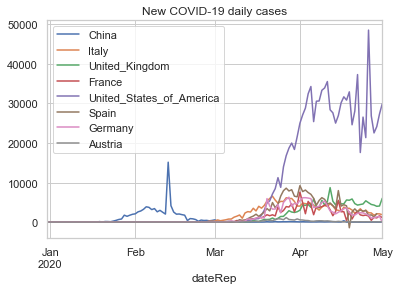

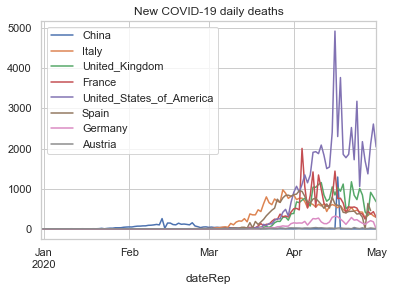

In [105]:
# Derivative of COVID-19 cases (unscaled) i.e. new cases/days
# Selected countries merged on to 1 plot

# cases
df_all = pd.DataFrame()
for c in countries:
    # no need to transform, just sort on date
    df_all[c] = df[df["countriesAndTerritories"] == c]["cases"].sort_index()
ax = df_all.plot(title="New COVID-19 daily cases")
ax.legend(df_all.columns)
fig.tight_layout()
plt.savefig("docs/graphs/rates/new_covid-19_daily_cases.png")

# deaths
df_all = pd.DataFrame()
for c in countries:
    df_all[c] = df[df["countriesAndTerritories"] == c]["deaths"].sort_index()
ax = df_all.plot(title="New COVID-19 daily deaths")
ax.legend(df_all.columns)
fig.tight_layout()
plt.savefig("docs/graphs/rates/new_covid-19_daily_deaths.png")

### Remarks
These graphs show the rise of the virus over its lifetime. The peak of each curve is when the virus is spreading fastest through a population. The fall of the curve is when the virus is slowing down and reaching the end of its spread.

* These derivative curves show more clearly the rate at which the virus is spreading. Temporary decreases often give offer a false hope and the infection rate soon returns to previously higher levels. This may be due to changes in the spread of the virus, delayed reporting of cases over weekends etc.

* The shape of the curve generally follows a bell-curve shape, but there is concern that the peak starts to plateau over a prolonged period before dropping. However, the virus appears to be clearly slowing down in some countries (e.g. Austria).

* There is a fear over the longer term that the infection rate may rise again as social distancing measures are relaxed (a so-called "2nd wave").

## Country-specific daily infections and deaths

These graphs show how daily rates of deaths vary over time for selected countries.

In [106]:
# grid line with multiple y-axes us confusing
sns.set(style="white")

# Derivative of COVID-19 cases (unscaled) i.e. new cases/days
# 1 graph per country. Cases and deaths plotted on separate y-axes
for c in df["countriesAndTerritories"].unique():
    # no need to transform, just sort on date
    ax_cases = df[df["countriesAndTerritories"] == c].sort_index().plot(y="cases", legend=False)
    ax_deaths = ax_cases.twinx()
    ax_deaths = df[df["countriesAndTerritories"] == c].sort_index().plot(y="deaths", color="red", ax=ax_deaths)
    
    ax_cases.set_title("New COVID-19 daily cases and deaths - %s" % c)
    ax_cases.set_ylabel("cases")
    ax_deaths.set_ylabel("deaths")
    plt.legend(handles=[mpatches.Patch(label="COVID-19 infections"), mpatches.Patch(color="red", label="COVID-19 deaths")], loc=2)
    plt.tight_layout()
    plt.savefig("docs/graphs/countries/%s_-_new_covid-19_daily_cases_and_deaths.png" % c)
    #plt.show()
    plt.close()
    #break

### Remarks
* The rates of increase/decrease in new COVID-19 infections and deaths have very similar rates. The curves for countries such as Italy and the United States show clearly how changes in death rates lag the infection rates: peaks in the daily infection rate lead to peaks in the daily recorded deaths some days later.

## Country-specific cumulative infections and deaths

Thes graphs show the total COVID infections and deaths for each country

In [107]:
sns.set(style="whitegrid")

# helper function to plot all countries
def plot_over_time(y, title, filename):
    for log_scaling, title_suffix, file_suffix in [(False, "", ""), (True, " with logarithmic scale", "_with_logarithmic_scale")]:
        ax = None
        for c in df["countriesAndTerritories"].unique():
            # transform daily delta into cumulative
            df_c = df[df["countriesAndTerritories"] == c][[y]].sort_index().cumsum()
            
            ax = df_c.plot(title=title + title_suffix + " - " + c, logy=log_scaling)
            ax.set_ylabel(y)
            
            # 5 day rolling mean to smooth curve
            df_rolling = df_c.rolling(5).mean().rename({y: y + " (rolling)"}, axis="columns")
            df_rolling.plot(ax=ax, title=title + title_suffix + " - " + c, logy=log_scaling)
            plt.tight_layout()

            plt.savefig("docs/graphs/countries/%s_-_%s.png" % (c, filename + file_suffix))
            #plt.show()
            plt.close()
            #break
            

plot_over_time("cases", "COVID-19 cases over time", "covid-19_cases_over_time")
plot_over_time("deaths", "COVID-19 deaths over time", "covid-19_deaths_over_time")

/Users/paul/.pyenv/versions/3.8.2/envs/covid_ml/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:1000: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  vi = tuple(self.axis.get_view_interval())
/Users/paul/.pyenv/versions/3.8.2/envs/covid_ml/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:1000: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  vi = tuple(self.axis.get_view_interval())
/Users/paul/.pyenv/versions/3.8.2/envs/covid_ml/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:520: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()
/Users/paul/.pyenv/versions/3.8.2/envs/covid_ml/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:520: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_mino

/Users/paul/.pyenv/versions/3.8.2/envs/covid_ml/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:520: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()
/Users/paul/.pyenv/versions/3.8.2/envs/covid_ml/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:520: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()
/Users/paul/.pyenv/versions/3.8.2/envs/covid_ml/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:1000: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  vi = tuple(self.axis.get_view_interval())
/Users/paul/.pyenv/versions/3.8.2/envs/covid_ml/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:1000: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  vi = tuple(self.axis.get_vie

## Country-specific cases & 5-day rolling mean

In [108]:
# grid line with multiple y-axes us confusing
sns.set(style="whitegrid")

# Derivative of COVID-19 cases (unscaled) i.e. new cases/days
# 1 graph per country. Cases and deaths plotted on separate y-axes
for c in df["countriesAndTerritories"].unique():
    # no need to transform, just sort on date
    df_c = df[df["countriesAndTerritories"] == c][["cases"]].sort_index()

    ax_cases = df_c.plot(legend=True)
    ax_cases.set_title("New COVID-19 daily cases and 5 day rolling mean - %s" % c)
    ax_cases.set_ylabel("cases")
    
    # 5 day rolling mean to smooth curve
    df_rolling = df_c.rolling(5).mean().rename({"cases": "cases (rolling)"}, axis="columns")
    df_rolling.plot(ax=ax_cases, legend=True)

    plt.tight_layout()
    plt.savefig("docs/graphs/countries/%s_-_new_covid-19_daily_cases_and_5_day_rolling_mean.png" % c)
    #plt.show()
    plt.close()
    #break

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pand

---
# Unused

Text(0, 0.5, 'deaths')

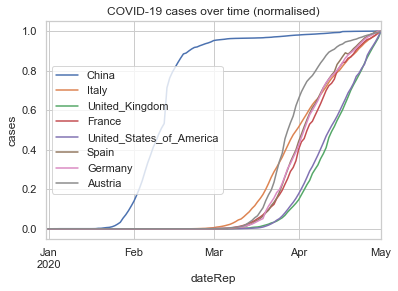

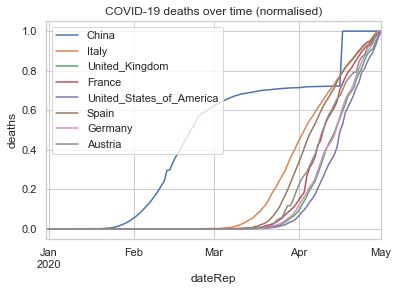

In [109]:
# COVID-19 cases for selected countries (normalise 0-1)
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

ax_cases = None
ax_deaths = None

# extract data for each country
for c in countries:
    df_c = df[df["countriesAndTerritories"] == c][["cases", "deaths"]].sort_index().cumsum()
    
    # normalise the values 0-1
    np_scaled = min_max_scaler.fit_transform(df_c)
    df_c_normalized = pd.DataFrame(np_scaled, columns=df_c.columns, index=df_c.index)
    
    ax_cases = df_c_normalized.plot(ax=ax_cases, y="cases", title="COVID-19 cases over time (normalised)")
    ax_deaths = df_c_normalized.plot(ax=ax_deaths, y="deaths", title="COVID-19 deaths over time (normalised)")

ax_cases.legend(countries)
ax_cases.set_ylabel("cases")
ax_deaths.legend(countries)
ax_deaths.set_ylabel("deaths")

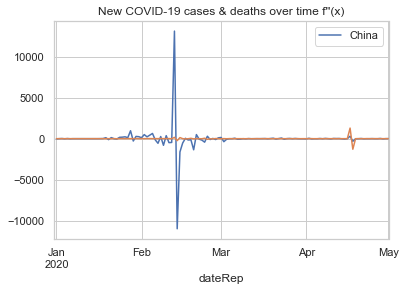

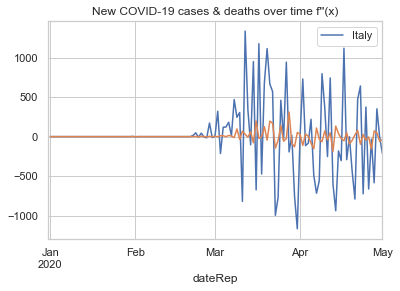

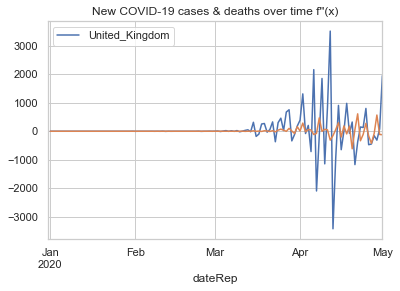

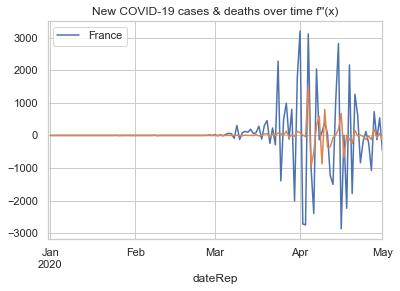

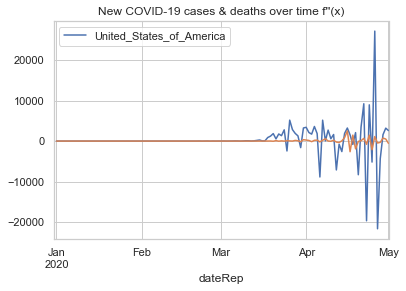

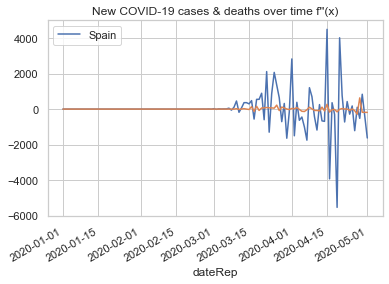

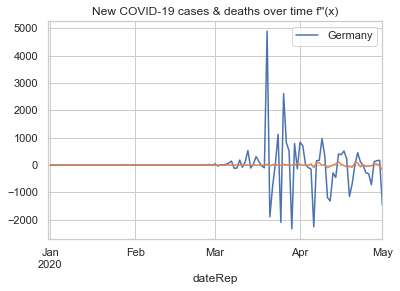

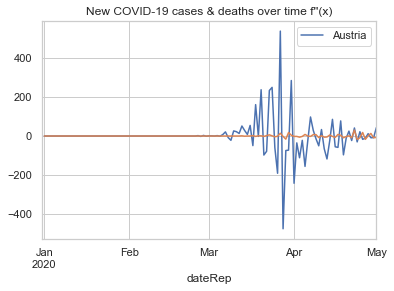

In [110]:
# 2nd derivative of COVID-19 cases (unscaled) i.e. new cases/days
# 1 graph per country
# Shows when the infection rates increase/decrease
ax = None
for c in countries:
    # transform daily delta into cumulative'
    ax = df[df["countriesAndTerritories"] == c][["cases", "deaths"]].sort_index().diff(axis=0).plot(title="New COVID-19 cases & deaths over time f''(x)")
    ax.legend([c])
    #plt.savefig("docs/graphs/countries_covid_derivative2_%s.png" % c)